In [21]:
import os
import glob
import h5py
import io
import scipy
from scipy import signal
from scipy.io import wavfile
from scipy.signal import stft, istft, medfilt
from scipy.signal import butter, lfilter, filtfilt
from scipy.io.wavfile import write
from scipy.signal import spectrogram, get_window
from scipy.signal import decimate


import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

In [22]:
import DAS_toolkit
from DAS_toolkit import read_OptaSense_single, read_OptaSense_multi
from DAS_toolkit import raw_to_phase_strain
from DAS_toolkit import decimate_das_data, butter_lowpass_filter
from DAS_toolkit import calculate_FBE, calculate_FBE_dB, plot_waterfall_single, plot_waterfall_multi

from DAS_toolkit import get_audio_from_DAS

* *read_OptaSense_file
* raw_to_strain
* compute_actual_frequencies
* calculate_FBE_dB
* plot_waterfall_single_figsize_time_Ns


In [23]:
def read_OptaSense_file(filename):
    # Open the HDF5 file(s)
    file = h5py.File(filename, 'r')
    raw_data = file['/Acquisition/Raw[0]/RawData']

    # Check dimensions of this raw_data matrix.
    print("Check dimensions of this raw_data matrix. Rows and columns should correspond to time steps and channels, respectively. If the matrix is not read in this form automatically, simply take its transpose.")

    return raw_data

In [24]:
def raw_to_strain(raw_data, n_FRI, Lgauge, PSF):
  phase_data = raw_data / (2 ** 15 / np.pi)
  strain_data = (Lambd / (4 * np.pi * n_FRI * Lgauge * PSF)) * phase_data * 1e6

  # if start_at_zero_strain == 1:
  #   strain_data -= strain_data[0, :]

  return strain_data, phase_data

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_waterfall_single_figsize_time_Ns(time_incr, filename, FBE_mat, colors, clim_limits, title, samplingRate, overlapPercent, fftSize, time_start, time_end, xlim_min, xlim_max, ylim_min, ylim_max, figsize=(10, 6)):
    """
    Function to plot the waterfall plot with time in seconds on the x-axis.
    
    Parameters:
    FBE_mat (ndarray): The matrix containing the FBE values.
    colors (list): List of colors for the colormap.
    clim_limits (tuple): Color limits for the plot.
    title (str): Title of the plot.
    samplingRate (float): Sampling rate in Hz.
    overlapPercent (float): Overlap percentage for FFT.
    fftSize (int): Size of the FFT.
    time_start (float): Start time in seconds for the plot.
    time_end (float): End time in seconds for the plot.
    xlim_min (float): Minimum x-axis limit in seconds.
    xlim_max (float): Maximum x-axis limit in seconds.
    figsize (tuple): Size of the figure (width, height).
    """
    # Define the custom colormap
    cmap = 'viridis'

    # Calculate the time in seconds for each time step
    overlapStepSize = int(fftSize * (1 - overlapPercent / 100))
    n_tsteps = FBE_mat.shape[0]
    time_steps = np.arange(n_tsteps) * (overlapStepSize / samplingRate)

    # Filter the matrix and time steps for the desired time frame
    valid_indices = (time_steps >= time_start) & (time_steps <= time_end)
    FBE_mat_filtered = FBE_mat[valid_indices, :]
    time_steps_filtered = time_steps[valid_indices]

    # Transpose the matrix to put time on the x-axis and channels on the y-axis
    FBE_mat_transposed = FBE_mat_filtered.T

    # Flip the matrix along the y-axis to have channel 0 at the top
    FBE_mat_transposed = np.flipud(FBE_mat_transposed)

    plt.figure(figsize=figsize)
    img = plt.imshow(FBE_mat_transposed, aspect='auto', cmap=cmap, extent=[time_start, time_end, 0, FBE_mat.shape[1]])
    cbar = plt.colorbar(img)
    cbar.set_label('Power (dB µstrain²/Hz)')
    plt.clim(*clim_limits)
    plt.xlabel('Time (s)')
    plt.ylabel('Distance along fiber (m)')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlim(time_start, time_end)
    plt.ylim(0, FBE_mat.shape[1])
    plt.ylim(ylim_min, ylim_max) # (0, FBE_mat.shape[1])
    plt.xlim(xlim_min, xlim_max)
    plt.title(f'{filename}\n  overlapPercent={overlapPercent}, fftSize={fftSize}')
    
    # Set x-ticks to reflect time in seconds, spaced by 2 seconds
    xticks = np.arange(time_start, time_end + 1, time_incr) #2
    plt.xticks(ticks=xticks, labels=np.round(xticks, 2))

    plt.show()

# Example usage
# plot_waterfall_single_figsize_time_1s(FBE_mat, colors, clim_limits, title, samplingRate, overlapPercent, fftSize, time_start, time_end, xlim_min, xlim_max, figsize=(10, 6))


In [26]:
def compute_actual_frequencies(sampling_frequency, fft_size, desired_start_frequency, desired_end_frequency):
    """
    Notes to user:
    * Recall Nyquist theorem: maximum frequency you can inspect is half the sampling frequency
    * This function uses "inclusive" mode for band limit calculation
    """
    # Compute the frequency resolution
    df = sampling_frequency / fft_size
    
    # Compute the half-bin resolution
    half_bin_resolution = df / 2
    
    # Maximum frequency based on the FFT size
    max_freq = sampling_frequency / 2
    
    # Compute actual start & end frequencies
    actual_start = np.floor((desired_start_frequency + half_bin_resolution) / df) * df - half_bin_resolution
    actual_end = np.ceil((desired_end_frequency - half_bin_resolution) / df) * df + half_bin_resolution
    
    # Clip actual_end to be within the maximum frequency
    if actual_end > max_freq:
        actual_end = max_freq - half_bin_resolution
    
    return actual_start, actual_end

In [27]:
def butter_highpass(cutoff, fs, order):
    # Suggestion: try increasing the order from 1 to 5 and see what happens

    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [28]:
def butter_lowpass_filter(data, cutoff_frequency, sampling_rate, order=3):

    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency

    # Design low-pass Butterworth filter
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)

    # Apply the filter using filtfilt for zero-phase filtering
    filtered_data = filtfilt(b, a, data)

    return filtered_data

## REVISED FBE

In [29]:
from scipy.signal import hann
def calculate_FBE_dB_revised(ping_rate, decim_factor, overlapPercent, fftSize, das_data, n_tchunks, channels, freq_start, freq_end):
    """
    example:
    * channel = [150, 249] (must be in increasing order)
    """
    samplingRate = ping_rate / decim_factor
    n_channels = channels[1] - channels[0] + 1
    
    # Pre-calculate the window function
    FBE_window = hann(fftSize, sym=False)
    scalingFactor = (1.633333**2) / (fftSize * samplingRate)
    
    # Calculate frequency bins once instead of repeatedly
    freq = np.fft.fftfreq(fftSize, d=1/samplingRate)
    freq_mask = (freq >= freq_start) & (freq <= freq_end)
    
    # Pre-allocate the result matrix
    FBE_mat = np.zeros((n_tchunks, n_channels))
    
    # Extract the relevant channel data once - adjusted for the channel indexing
    channel_data = das_data[:, channels[0]-channels[0]:channels[1]-channels[0]+1]
    
    # Process each time chunk vectorized across all channels
    for i in range(n_tchunks):
        # Extract the current chunk for all channels at once
        chunk = channel_data[fftSize*i:fftSize*(i+1), :]
        
        # Subtract mean (along time axis) and apply window function
        windowed_chunk = (chunk - np.mean(chunk, axis=0)) * FBE_window[:, np.newaxis]
        
        # Compute FFT for all channels at once
        fft_output = np.fft.fft(windowed_chunk, axis=0)
        
        # Calculate power
        fft_power = scalingFactor * np.abs(fft_output) ** 2
        
        # Double the power for positive frequencies (except DC)
        fft_power[1:] = 2 * fft_power[1:]
        
        # Calculate the mean power in the frequency range for all channels and convert to dB
        mean_power = np.mean(fft_power[freq_mask, :], axis=0)
        FBE_mat[i, :] = 10 * np.log10(mean_power)
    
    return FBE_mat

## THRESHOLDING

In [ ]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt

def count_trajectories(waterfall_data, threshold=None, min_size=100):
    """
    Count vehicle trajectories in DAS waterfall plot using thresholding
    
    Parameters:
    -----------
    waterfall_data: 2D numpy array
        The DAS waterfall plot (space-time matrix)
    threshold: float or None
        Intensity threshold value. If None, Otsu's method is used
    min_size: int
        Minimum size (in pixels) for a component to be counted as a vehicle
        
    Returns:
    --------
    count: int
        Number of detected vehicles
    labeled_image: 2D numpy array
        Image with labeled components
    """
    # 1. Pre-processing
    # Apply median filter to reduce noise
    filtered_data = ndimage.median_filter(waterfall_data, size=3)
    
    # 2. Thresholding
    if threshold is None:
        # Use Otsu's method to find optimal threshold
        _, binary = cv2.threshold(filtered_data.astype(np.uint8), 
                                 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        # Use provided threshold
        binary = (filtered_data > threshold).astype(np.uint8) * 255
    
    # 3. Morphological operations to clean up
    # Create kernel for morphological operations
    kernel = np.ones((3, 3), np.uint8)
    
    # Close small gaps
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Remove small noise
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # 4. Connected component analysis
    # Label connected components
    labeled, num_components = ndimage.label(binary)
    
    # Calculate size of each component
    component_sizes = np.bincount(labeled.ravel())
    
    # Filter out small components (noise)
    too_small = component_sizes < min_size
    too_small_mask = too_small[labeled]
    labeled[too_small_mask] = 0
    
    # Count remaining components (excluding background which is 0)
    unique_labels = np.unique(labeled)
    unique_labels = unique_labels[unique_labels > 0]  # Remove background
    count = len(unique_labels)
    
    return count, labeled

# Visualization
def visualize_results(original, labeled, count):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='viridis')
    plt.title('Original FBE Waterfall')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title(f'Detected Trajectories: {count} vehicles')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

---

# Set-up and read data

#### <font color='magenta'> GL = 2m </font>

In [31]:
# Parameters
Lambd = 1550e-9
Lgauge = 2.041905
n_FRI = 1.468200
PSF = 0.78
ping_rate = 20e3
decim_factor = 4
fs = ping_rate * (1/decim_factor)
nyquist = 0.5 * fs

---

# Try thresholding

Try working with the pre-computed FBE matrices

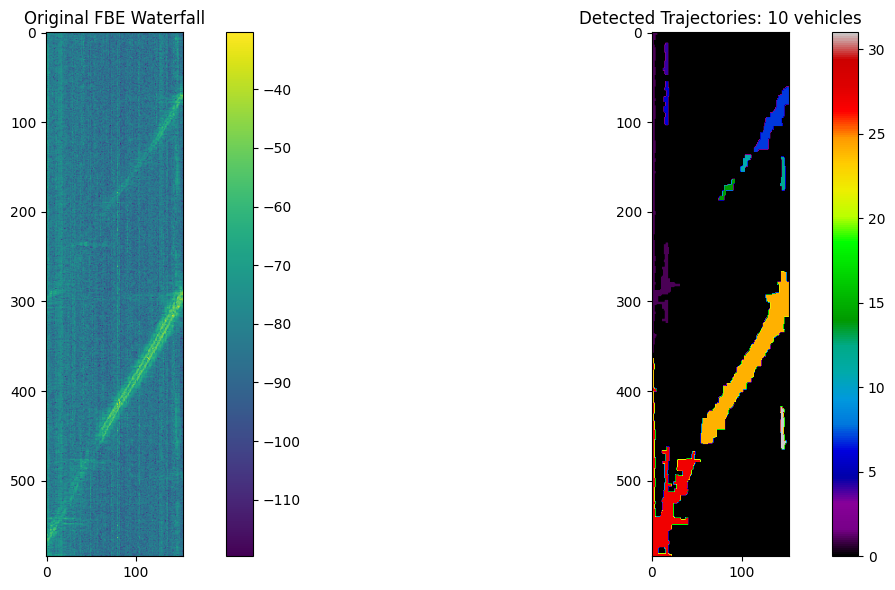

In [32]:
FBE_file = r"F:\_0_Dissertation_DAS\_Claremont_24hr\FBE_matrices_2\FBE_sensor_2024-11-24T183536-0800_0s-30s_0.1-10Hz.npy"
FBE_file_npy = np.load(FBE_file)
count, labeled_image = count_trajectories(FBE_file_npy)
visualize_results(FBE_file_npy,  labeled_image, count)

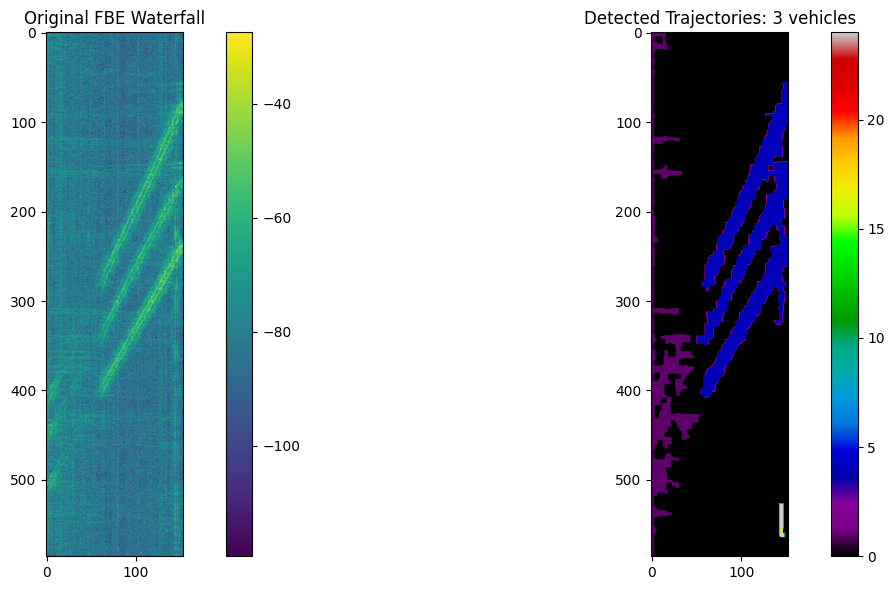

In [33]:
FBE_file = r"F:\_0_Dissertation_DAS\_Claremont_24hr\FBE_matrices_2\FBE_sensor_2024-11-24T183536-0800_30s-60s_0.1-10Hz.npy"
FBE_file_npy2= np.load(FBE_file)
count, labeled_image = count_trajectories(FBE_file_npy2)
visualize_results(FBE_file_npy2, labeled_image, count)

---

# Do it for all 0.1-10 Hz FBE matrices

In [34]:
import numpy as np
import cv2
import os
import csv
from scipy import ndimage
import matplotlib.pyplot as plt

# --- Vehicle counting function (same as yours) ---
def count_trajectories(waterfall_data, threshold=None, min_size=100):
    filtered_data = ndimage.median_filter(waterfall_data, size=3)

    if threshold is None:
        _, binary = cv2.threshold(filtered_data.astype(np.uint8), 
                                  0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        binary = (filtered_data > threshold).astype(np.uint8) * 255

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    labeled, _ = ndimage.label(binary)
    component_sizes = np.bincount(labeled.ravel())
    too_small = component_sizes < min_size
    too_small_mask = too_small[labeled]
    labeled[too_small_mask] = 0

    unique_labels = np.unique(labeled)
    unique_labels = unique_labels[unique_labels > 0]
    count = len(unique_labels)

    return count, labeled

# --- Directory to scan ---
folder_path = r"F:\_Claremont_24hr\DAS_all_FBE_2"
output_csv_path = os.path.join(folder_path, "vehicle_counts.csv")

# --- Scan and process all .npy files ---
results = []
for filename in os.listdir(folder_path):
    if filename.endswith(".npy"):
        file_path = os.path.join(folder_path, filename)
        try:
            fbe_data = np.load(file_path)
            count, _ = count_trajectories(fbe_data)
            results.append((filename, count))
            print(f"Processed {filename}: {count} vehicles")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# --- Save to CSV ---
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Vehicle_Count"])
    writer.writerows(results)

print(f"\nVehicle counts saved to {output_csv_path}")


Processed FBE_sensor_2024-11-23T231921-0800_0s-30s_0.1-10Hz.npy: 8 vehicles
Processed FBE_sensor_2024-11-23T231921-0800_30s-60s_0.1-10Hz.npy: 7 vehicles
Processed FBE_sensor_2024-11-23T232021-0800_0s-30s_0.1-10Hz.npy: 4 vehicles
Processed FBE_sensor_2024-11-23T232021-0800_30s-60s_0.1-10Hz.npy: 3 vehicles
Processed FBE_sensor_2024-11-23T232121-0800_0s-30s_0.1-10Hz.npy: 7 vehicles
Processed FBE_sensor_2024-11-23T232121-0800_30s-60s_0.1-10Hz.npy: 5 vehicles
Processed FBE_sensor_2024-11-23T232221-0800_0s-30s_0.1-10Hz.npy: 4 vehicles
Processed FBE_sensor_2024-11-23T232221-0800_30s-60s_0.1-10Hz.npy: 17 vehicles
Processed FBE_sensor_2024-11-23T232321-0800_0s-30s_0.1-10Hz.npy: 13 vehicles
Processed FBE_sensor_2024-11-23T232321-0800_30s-60s_0.1-10Hz.npy: 7 vehicles
Processed FBE_sensor_2024-11-23T232421-0800_0s-30s_0.1-10Hz.npy: 1 vehicles
Processed FBE_sensor_2024-11-23T232421-0800_30s-60s_0.1-10Hz.npy: 6 vehicles
Processed FBE_sensor_2024-11-23T232522-0800_0s-30s_0.1-10Hz.npy: 6 vehicles
Proc

---

Compute metrics

In [45]:
import ast  # safer than eval

def safe_parse(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except Exception:
            return []
    elif isinstance(val, list):
        return val
    else:
        return []

# # Apply the safe parser
# ground_truth_df['class_2_tracks'] = ground_truth_df['class_2_tracks'].apply(safe_parse)

# # Then continue as before
# ground_truth_df['Ground_Truth_Count'] = ground_truth_df['class_2_tracks'].apply(len)


In [47]:
import pandas as pd
import numpy as np
import re
import ast
from sklearn.metrics import f1_score

# --- Load data ---
xlsx_path = r"F:\_Claremont_24hr\das_gopro_mapping_conf0.7.xlsx"
csv_path = r"F:\_Claremont_24hr\DAS_all_FBE_2\vehicle_counts_redacted.csv"

# Load Excel and CSV
ground_truth_df = pd.read_excel(xlsx_path)
predicted_df = pd.read_csv(csv_path)

# --- Helper functions ---
def extract_key_from_dasfile(s):
    # Matches: sensor_2024-11-23T231921-0800
    match = re.search(r'sensor_\d{4}-\d{2}-\d{2}T\d{6}-\d{4}', str(s))
    return match.group(0) if match else None

def extract_key_from_filename(s):
    # Matches: FBE_sensor_2024-11-23T231921-0800 -> sensor_2024-11-23T231921-0800
    match = re.search(r'sensor_\d{4}-\d{2}-\d{2}T\d{6}-\d{4}', str(s))
    return match.group(0) if match else None

def safe_parse(track_str):
    try:
        return ast.literal_eval(track_str)
    except:
        return []

def bin_count(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    elif n == 2:
        return 2
    else:
        return 3

# --- Extract keys for merging ---
ground_truth_df['merge_key'] = ground_truth_df['DAS_File'].astype(str).apply(extract_key_from_dasfile)
predicted_df['merge_key'] = predicted_df['Filename'].astype(str).apply(extract_key_from_filename)

# Drop rows with missing keys
ground_truth_df = ground_truth_df.dropna(subset=['merge_key'])
predicted_df = predicted_df.dropna(subset=['merge_key'])

# Merge dataframes on extracted key
merged_df = pd.merge(ground_truth_df, predicted_df, on='merge_key', how='inner')

# Handle failed merge
if merged_df.empty:
    raise ValueError("Merged DataFrame is still empty. Check key extraction regex or file naming logic.")

# --- Parse and count vehicle tracks ---
merged_df['parsed_tracks'] = merged_df['class_2_tracks'].apply(safe_parse)
merged_df['Ground_Truth_Count'] = merged_df['parsed_tracks'].apply(len)

# Extract predictions and ground truth
y_true = merged_df['Ground_Truth_Count'].values
y_pred = merged_df['Vehicle_Count'].values

# --- Metrics ---
# Exact count accuracy
exact_match_acc = np.mean(y_true == y_pred)

# Distribution accuracy (binned)
binned_true = np.array([bin_count(x) for x in y_true])
binned_pred = np.array([bin_count(x) for x in y_pred])
distribution_acc = np.mean(binned_true == binned_pred)

# MAE
mae = np.mean(np.abs(y_true - y_pred))

# Off-by-one error rate
off_by_one = np.mean(np.abs(y_true - y_pred) <= 1)

# F1 Score (macro-averaged across exact counts)
max_label = max(y_true.max(), y_pred.max())
f1 = f1_score(y_true, y_pred, average='macro', labels=range(max_label + 1))

# --- Print results ---
print("Exact Count Accuracy: {:.2f}%".format(exact_match_acc * 100))
print("Distribution Accuracy (bins: 0,1,2,≥3): {:.2f}%".format(distribution_acc * 100))
print("Mean Absolute Error (MAE): {:.2f}".format(mae))
print("Off-by-One Error Rate: {:.2f}%".format(off_by_one * 100))
print("F1 Score (macro, by count): {:.2f}".format(f1))

# Optional: show errors per row
merged_df['Error'] = merged_df['Ground_Truth_Count'] - merged_df['Vehicle_Count']


Exact Count Accuracy: 14.08%
Distribution Accuracy (bins: 0,1,2,≥3): 36.89%
Mean Absolute Error (MAE): 5.02
Off-by-One Error Rate: 30.46%
F1 Score (macro, by count): 0.02


C:\Users\Jaewon Saw HMMB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
